In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_excel('../power-plant.xlsx', sheet_name='Sheet1')
# df = pd.concat(pd.read_excel('../power-plant.xlsx', sheet_name=None), ignore_index=True) # use all 5 sheets

# rename columns
df.columns = ['Temperature', 'Exhaust_Vacuum', 'Ambient_Pressure', 'Relative_Humidity', 'Energy_Output']

# Define features (X) and target (y)
X = df.drop('Energy_Output', axis=1)
y = df['Energy_Output']

In [5]:
# split the data: 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 7654
Test set size: 1914


# Data Visualiztion

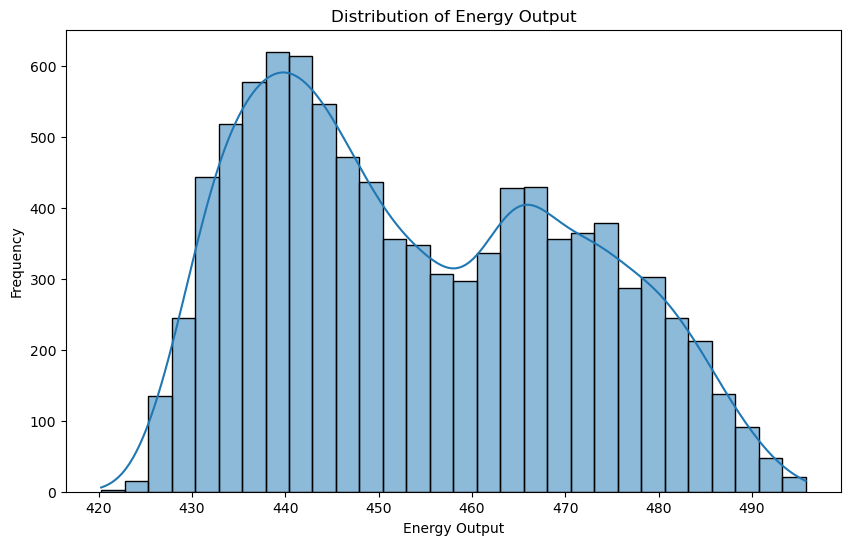

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Energy Output')
plt.xlabel('Energy Output')
plt.ylabel('Frequency')
plt.show()

## Polynomial Features

In [7]:
poly = PolynomialFeatures(degree=12, include_bias=False)
# degree = 12 -> to make the model more complex and prone to overfitting

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of polynomial features: {X_train_poly.shape[1]}")

Original number of features: 4
Number of polynomial features: 1819


## Feature Scaling

Rescales every feature so that they all have a mean of 0 and a standard deviation of 1. <br>
Important for regularization techniques like Lasso and Ridge. <br>
Also prevent big numerical values because of polynomial features. 

In [8]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Model 1: Overfit

## Training

In [9]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_scaled, y_train)

LinearRegression()

## Evaluate

In [10]:
y_train_pred_base = poly_reg_model.predict(X_train_scaled)
y_test_pred_base = poly_reg_model.predict(X_test_scaled)

rmse_train_base = np.sqrt(mean_squared_error(y_train, y_train_pred_base))
rmse_test_base = np.sqrt(mean_squared_error(y_test, y_test_pred_base))

print("--- Model 1: Baseline Polynomial Regression ---")
print(f"Training RMSE: {rmse_train_base:.4f}")
print(f"Test RMSE:     {rmse_test_base:.4f}")
# train RMSE < test RMSE -> overfitting
print("\nObservation: The test RMSE is higher than the training RMSE, indicating some overfitting.")

--- Model 1: Baseline Polynomial Regression ---
Training RMSE: 3.5648
Test RMSE:     16.0480

Observation: The test RMSE is higher than the training RMSE, indicating some overfitting.


## Graph

From the graph, we can see some test data points that are far away from the predicted line, indicating that the model is not generalizing well to unseen data.

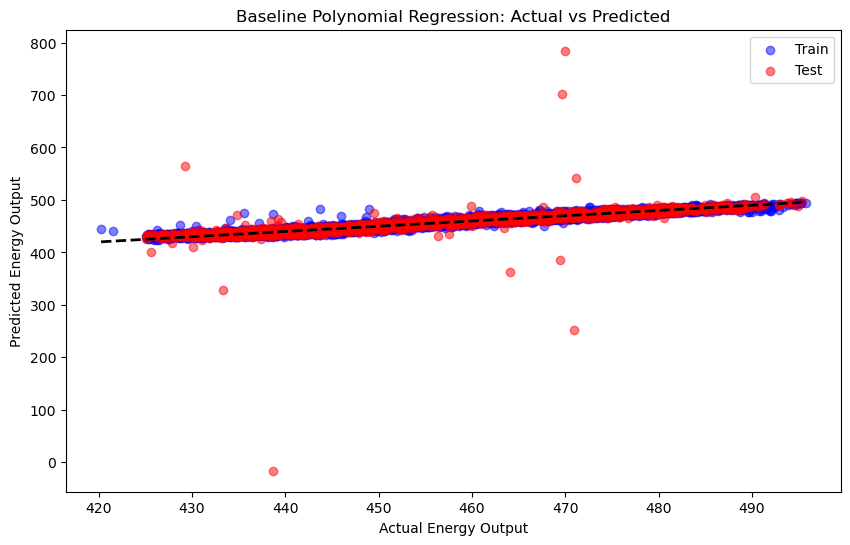

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred_base, color='blue', alpha=0.5, label='Train')
plt.scatter(y_test, y_test_pred_base, color='red', alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # k-- for dashed line, lw=2 for line width
# [y.min(), y.max()] to ensure the line covers the full range of actual values

plt.xlabel('Actual Energy Output')
plt.ylabel('Predicted Energy Output')
plt.title('Baseline Polynomial Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Model 2: LASSO Regularization

In [ ]:
# cv=5 means 5-fold cross-validation
lasso_model = LassoCV(cv=5, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate performance (RMSE)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

print("\n--- Model 2: Lasso (L1) Regularization ---")
print(f"Best alpha found by CV: {lasso_model.alpha_:.6f}")
print(f"Training RMSE: {rmse_train_lasso:.4f}")
print(f"Test RMSE:     {rmse_test_lasso:.4f}")
print("\nObservation: The gap between training and test RMSE is much smaller. The model generalizes better.")


--- Model 2: Lasso (L1) Regularization ---
Best alpha found by CV: 0.016185
Training RMSE: 4.2540
Test RMSE:     4.2199

Observation: The gap between training and test RMSE is much smaller. The model generalizes better.


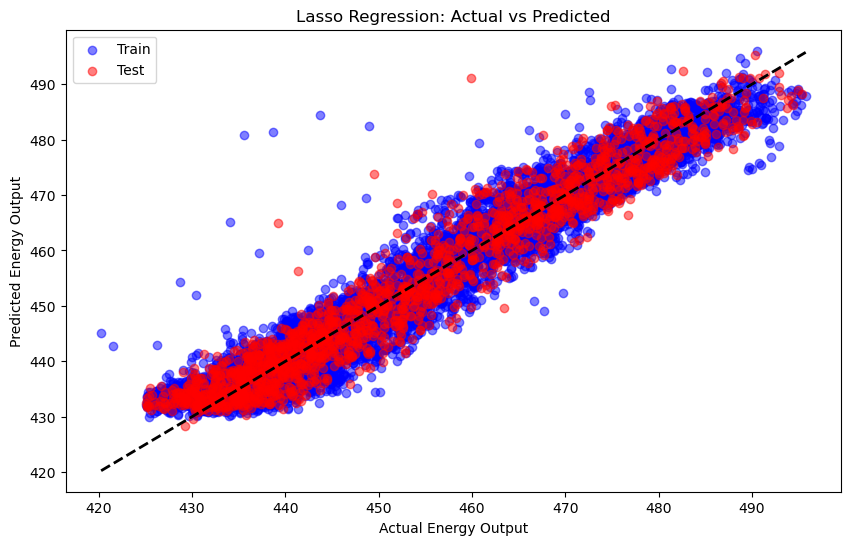

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred_lasso, color='blue', alpha=0.5, label='Train')
plt.scatter(y_test, y_test_pred_lasso, color='red', alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Energy Output')
plt.ylabel('Predicted Energy Output')
plt.title('Lasso Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Model 3: Ridge Regularization

In [ ]:
# alphas=np.logspace(-3, 3, 100) generates 100 values from 0.001 to 1000
# alpha controls the strength of regularization
ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_model.fit(X_train_scaled, y_train)
# this may take a while to run (5m38s for me)

RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87381742e-0...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
        cv=5)

In [ ]:
# Make predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Calculate performance (RMSE)
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print("\n--- Model 3: Ridge (L2) Regularization ---")
print(f"Best alpha found by CV: {ridge_model.alpha_:.4f}")
print(f"Training RMSE: {rmse_train_ridge:.4f}")
print(f"Test RMSE:     {rmse_test_ridge:.4f}")
print("\nObservation: Ridge also closed the gap between training and test performance effectively.")


--- Model 3: Ridge (L2) Regularization ---
Best alpha found by CV: 0.0010
Training RMSE: 3.9934
Test RMSE:     3.9973

Observation: Ridge also closed the gap between training and test performance effectively.


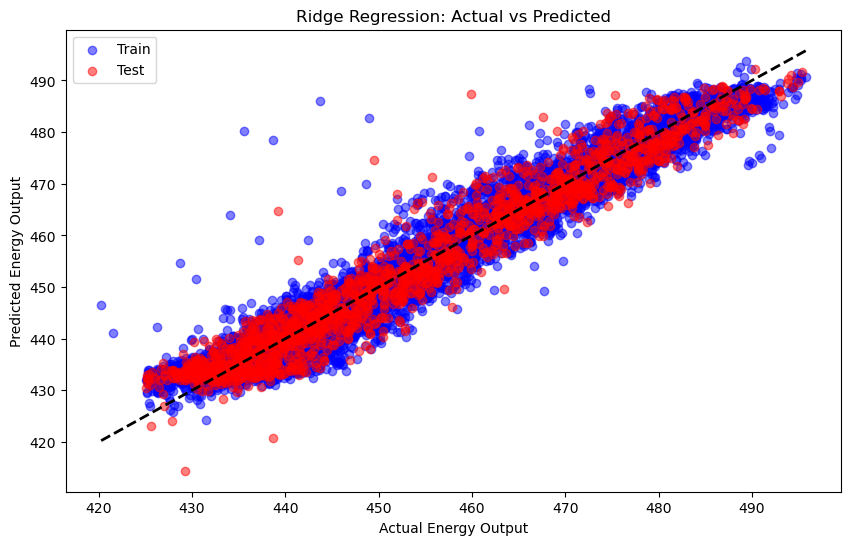

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred_ridge, color='blue', alpha=0.5, label='Train')
plt.scatter(y_test, y_test_pred_ridge, color='red', alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Energy Output')
plt.ylabel('Predicted Energy Output')
plt.title('Ridge Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Graphs

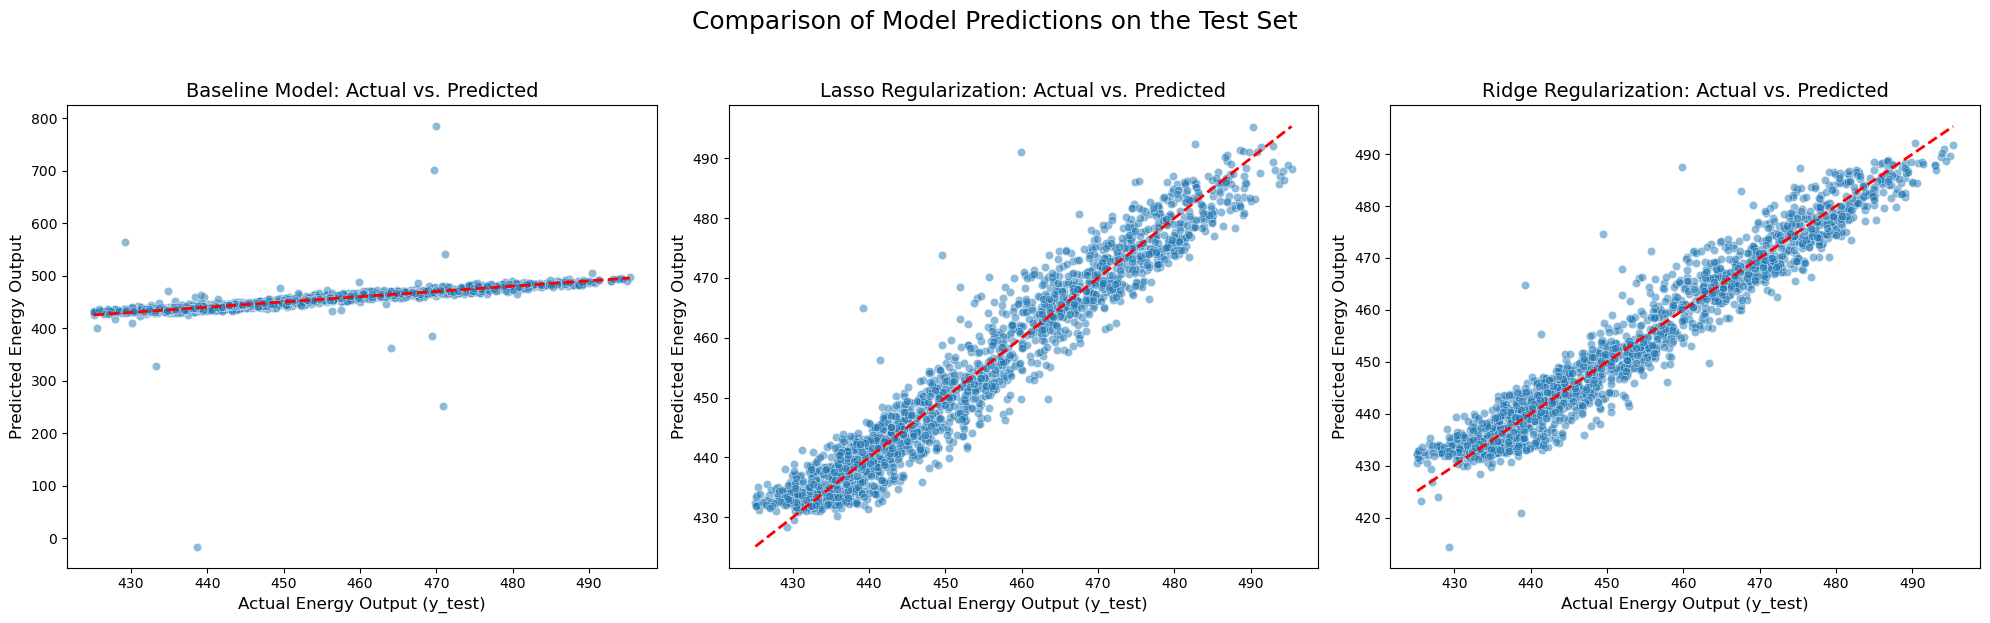

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot for Baseline Model ---
sns.scatterplot(x=y_test, y=y_test_pred_base, ax=axes[0], alpha=0.5)
axes[0].set_title('Baseline Model: Actual vs. Predicted', fontsize=14)
axes[0].set_xlabel('Actual Energy Output (y_test)', fontsize=12)
axes[0].set_ylabel('Predicted Energy Output', fontsize=12)
# Add the perfect prediction line
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# --- Plot for Lasso Model ---
sns.scatterplot(x=y_test, y=y_test_pred_lasso, ax=axes[1], alpha=0.5)
axes[1].set_title('Lasso Regularization: Actual vs. Predicted', fontsize=14)
axes[1].set_xlabel('Actual Energy Output (y_test)', fontsize=12)
axes[1].set_ylabel('Predicted Energy Output', fontsize=12)
# Add the perfect prediction line
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)


# --- Plot for Ridge Model ---
sns.scatterplot(x=y_test, y=y_test_pred_ridge, ax=axes[2], alpha=0.5)
axes[2].set_title('Ridge Regularization: Actual vs. Predicted', fontsize=14)
axes[2].set_xlabel('Actual Energy Output (y_test)', fontsize=12)
axes[2].set_ylabel('Predicted Energy Output', fontsize=12)
# Add the perfect prediction line
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

fig.suptitle('Comparison of Model Predictions on the Test Set', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

The LassoCV and RidgeCV functions are convenient helpers that perform cross-validation internally to find the best alpha, but they hide the process from you.

--- Running Manual 5-Fold Cross-Validation ---
Fold 1: Validation RMSE = 10.2606
Fold 2: Validation RMSE = 58.6965
Fold 3: Validation RMSE = 19.6547
Fold 4: Validation RMSE = 8.6549
Fold 5: Validation RMSE = 8.9302


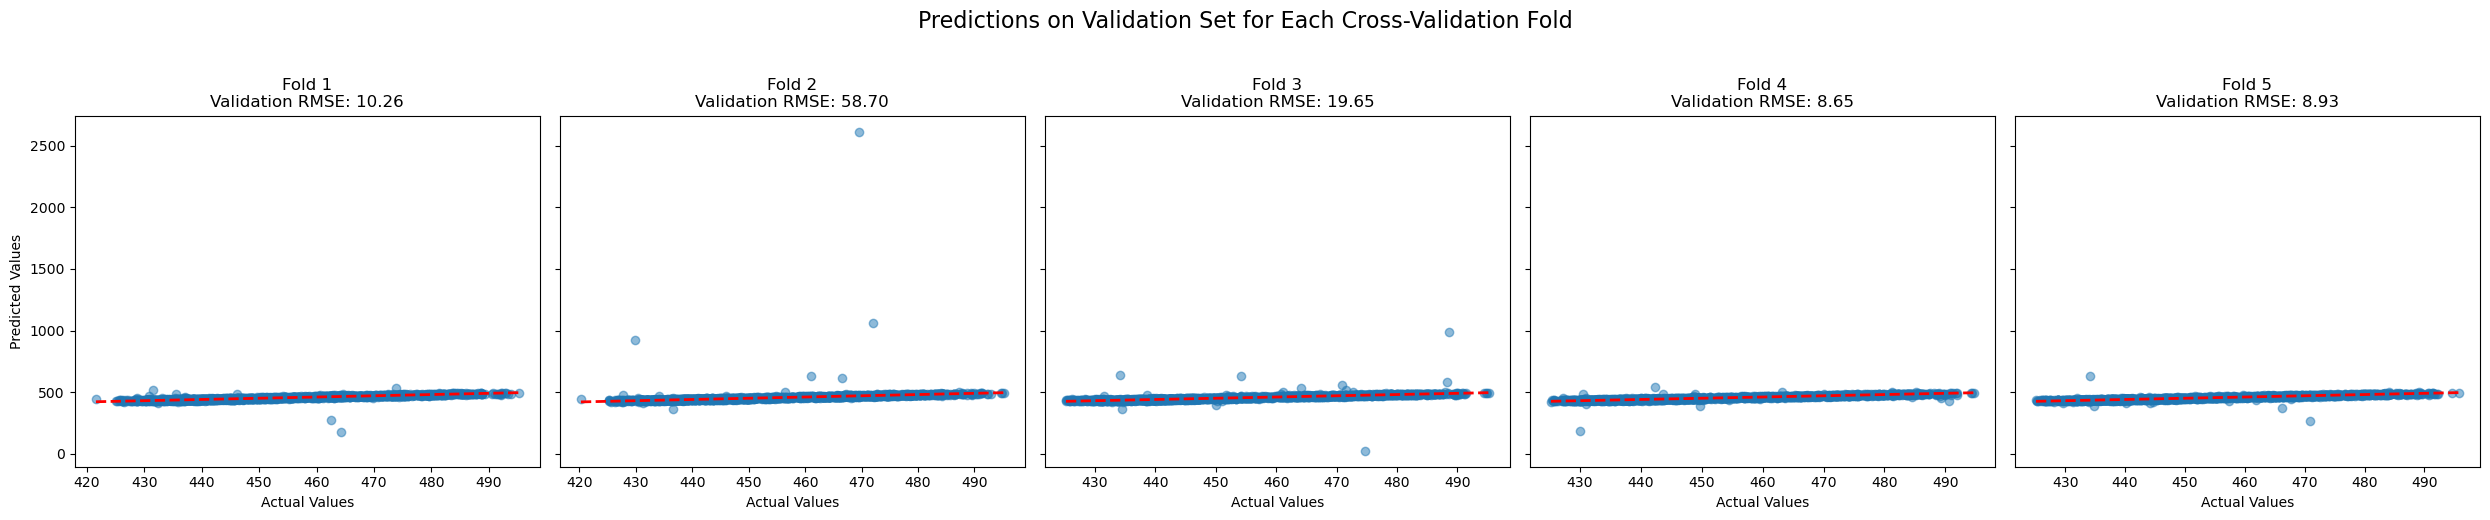

In [ ]:
from sklearn.model_selection import KFold

# n_splits=5 means we will create 5 folds.
# shuffle=True is important to randomize the data before splitting.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a figure to hold the plots for each fold
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
fold_number = 1

print("--- Running Manual 5-Fold Cross-Validation ---")

for train_index, val_index in kf.split(X_train_scaled):
    
    # --- Split the data for this fold ---
    # training part of the fold (~64% of total data)
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
    # validation part of the fold (~16% of total data)
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # --- Train a new model ---
    model_for_fold = LinearRegression()
    model_for_fold.fit(X_fold_train, y_fold_train)
    
    # --- Make predictions on the fold's validation set ---
    y_fold_pred = model_for_fold.predict(X_fold_val)
    
    # --- Calculate and print the score ---
    rmse_fold = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
    print(f"Fold {fold_number}: Validation RMSE = {rmse_fold:.4f}")
    
    # --- Plotting for this fold ---
    ax = axes[fold_number - 1]
    ax.scatter(y_fold_val, y_fold_pred, alpha=0.5)
    ax.plot([y_fold_val.min(), y_fold_val.max()], [y_fold_val.min(), y_fold_val.max()], 'r--', lw=2)
    ax.set_title(f'Fold {fold_number}\nValidation RMSE: {rmse_fold:.2f}')
    ax.set_xlabel('Actual Values')
    if fold_number == 1:
        ax.set_ylabel('Predicted Values')
        
    fold_number += 1

plt.suptitle('Predictions on Validation Set for Each Cross-Validation Fold', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()

# Test each model accuracy

| AT	| V	    | AP	   | RH	   | PE     |
|-------|-------|----------|-------|--------|
| Temperature | Exhaust_Vacuum | Ambient_Pressure | Relative_Humidity | Energy_Output |
| 9.59	| 38.56	| 1,017.01 | 60.10 | 481.30 |


In [ ]:
# create a dataframe for the new data point
new_data = pd.DataFrame({
    'Temperature': [9.59],
    'Exhaust_Vacuum': [38.56],
    'Ambient_Pressure': [1017.01],
    'Relative_Humidity': [60.10]
})

# transform the new data point
new_data_scaled = scaler.transform(poly.transform(new_data))

In [ ]:
# predict for each model
y_pred_base = poly_reg_model.predict(new_data_scaled)
y_pred_lasso = lasso_model.predict(new_data_scaled)
y_pred_ridge = ridge_model.predict(new_data_scaled)

In [ ]:
print("\n--- Predictions for New Data Point ---")
print("Real Energy Output: 481.30")

print("\nPredictions:")
print(f"Baseline Model Prediction: {y_pred_base[0]:.2f}")
print(f"Lasso Model Prediction:    {y_pred_lasso[0]:.2f}")
print(f"Ridge Model Prediction:    {y_pred_ridge[0]:.2f}")

print("\nHow close are the predictions to the real value?")
print(f"Baseline model: {abs(y_pred_base[0] - 481.30):.2f}")
print(f"Lasso model:    {abs(y_pred_lasso[0] - 481.30):.2f}")
print(f"Ridge model:    {abs(y_pred_ridge[0] - 481.30):.2f}")


--- Predictions for New Data Point ---
Real Energy Output: 481.30

Predictions:
Baseline Model Prediction: 477.72
Lasso Model Prediction:    479.46
Ridge Model Prediction:    478.28

How close are the predictions to the real value?
Baseline model: 3.58
Lasso model:    1.84
Ridge model:    3.02


In [ ]:
# read data from all other sheets, except Sheet1
df_all = pd.concat(pd.read_excel('../power-plant.xlsx', sheet_name=['Sheet2', 'Sheet3', 'Sheet4', 'Sheet5']), ignore_index=True)

# rename columns
df_all.columns = ['Temperature', 'Exhaust_Vacuum', 'Ambient_Pressure', 'Relative_Humidity', 'Energy_Output']

# Define features (X) and target (y)
X_all = df_all.drop('Energy_Output', axis=1)
y_all = df_all['Energy_Output']

# transform the new data points
X_all_poly = poly.transform(X_all)
X_all_scaled = scaler.transform(X_all_poly)

In [ ]:
# make predictions on the new dataset
y_all_pred_base = poly_reg_model.predict(X_all_scaled)
y_all_pred_lasso = lasso_model.predict(X_all_scaled)
y_all_pred_ridge = ridge_model.predict(X_all_scaled)

In [ ]:
# calculate performance (RMSE)
rmse_all_base = np.sqrt(mean_squared_error(y_all, y_all_pred_base))
rmse_all_lasso = np.sqrt(mean_squared_error(y_all, y_all_pred_lasso))
rmse_all_ridge = np.sqrt(mean_squared_error(y_all, y_all_pred_ridge))

print("\n--- Model Performance on New Dataset (Sheets 2-5) ---")
print(f"Baseline Model RMSE: {rmse_all_base:.4f}")
print(f"Lasso Model RMSE: {rmse_all_lasso:.4f}")
print(f"Ridge Model RMSE: {rmse_all_ridge:.4f}")


--- Model Performance on New Dataset (Sheets 2-5) ---
Baseline Model RMSE: 7.8539
Lasso Model RMSE: 4.2472
Ridge Model RMSE: 3.9941


## Graph

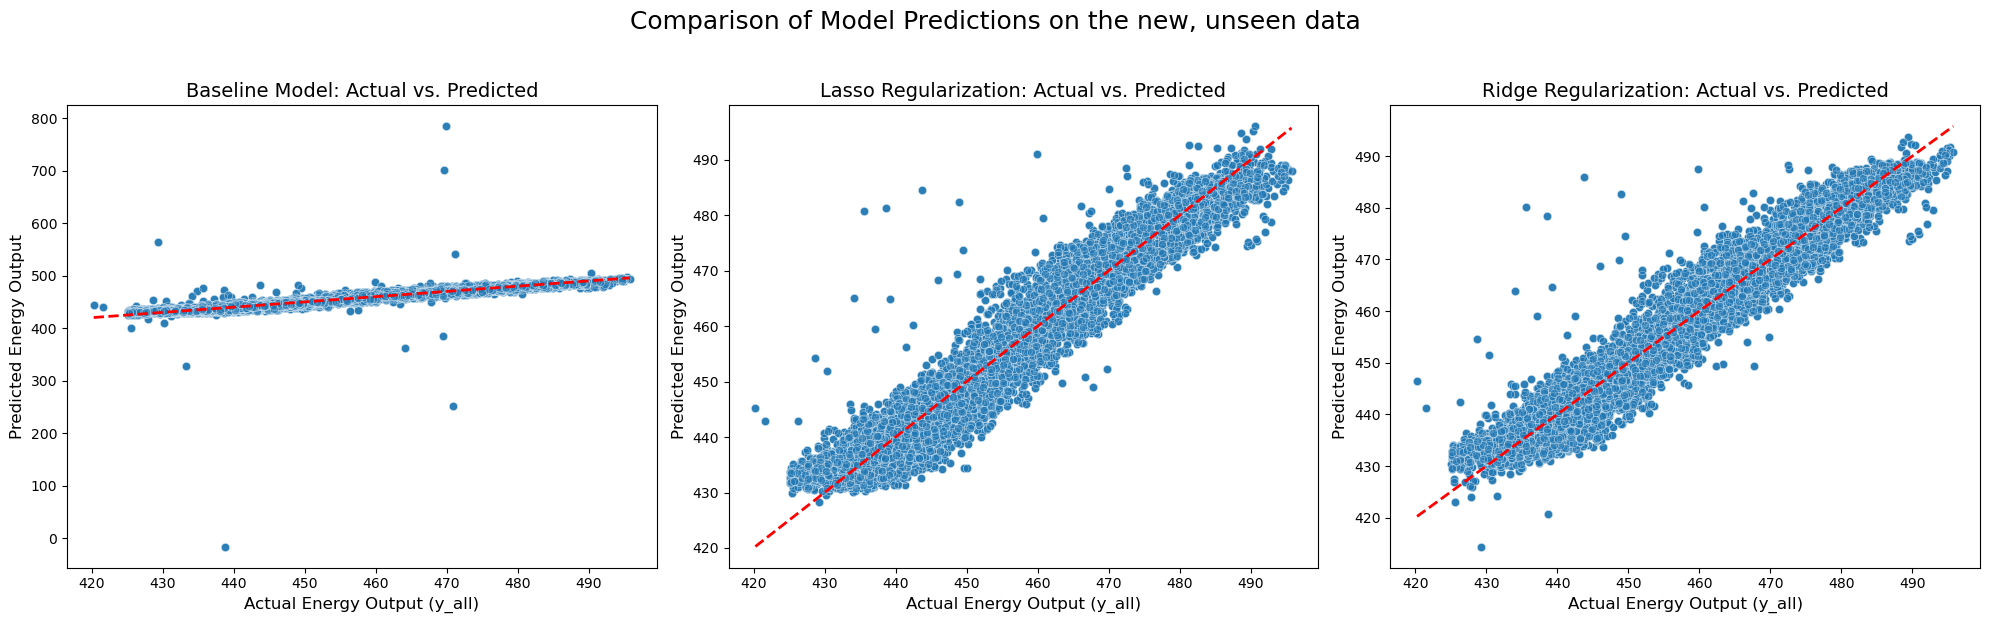

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Plot for Baseline Model ---
sns.scatterplot(x=y_all, y=y_all_pred_base, ax=axes[0], alpha=0.5)
axes[0].set_title('Baseline Model: Actual vs. Predicted', fontsize=14)
axes[0].set_xlabel('Actual Energy Output (y_all)', fontsize=12)
axes[0].set_ylabel('Predicted Energy Output', fontsize=12)
axes[0].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)

# --- Plot for Lasso Model ---
sns.scatterplot(x=y_all, y=y_all_pred_lasso, ax=axes[1], alpha=0.5)
axes[1].set_title('Lasso Regularization: Actual vs. Predicted', fontsize=14)
axes[1].set_xlabel('Actual Energy Output (y_all)', fontsize=12)
axes[1].set_ylabel('Predicted Energy Output', fontsize=12)
axes[1].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)


# --- Plot for Ridge Model ---
sns.scatterplot(x=y_all, y=y_all_pred_ridge, ax=axes[2], alpha=0.5)
axes[2].set_title('Ridge Regularization: Actual vs. Predicted', fontsize=14)
axes[2].set_xlabel('Actual Energy Output (y_all)', fontsize=12)
axes[2].set_ylabel('Predicted Energy Output', fontsize=12)
axes[2].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)

fig.suptitle('Comparison of Model Predictions on the new, unseen data', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

# Final 

### 1. Baseline Model
**Observation**: The data points form a nearly horizontal line. While the actual energy output (x-axis) varies from ~420 to ~490, the model's predictions (y-axis) are all clustered around a single value (~450). There are also several extreme outliers with very poor predictions.

**Interpretation**: This is a very poor model. It has almost no predictive power on the new data. It seems to have learned very little from the features and is essentially just predicting a value close to the average energy output, regardless of the input. This suggests the model has either failed to learn the underlying patterns (underfitting) or it overfit so badly to the training data that it cannot generalize at all.

=> *Conclusion*: This model is not useful for making predictions.



### 2. Lasso Regularization Model
**Observation**: The data points form a tight, diagonal cloud that is closely centered around the red dashed line. As the actual energy output increases, the predicted energy output increases proportionally.

**Interpretation**: This is a very good model. The strong linear relationship between the actual and predicted values shows that the model has successfully learned the underlying patterns in the data and is making accurate predictions. The points are relatively close to the ideal line, indicating low error.

=> *Conclusion*: The Lasso model generalizes well to unseen data and is highly effective.



### 3. Ridge Regularization Model
**Observation**: Similar to the Lasso model.

**Interpretation**: This is also a very good model.

=> *Conclusion*: The Ridge model is also an excellent and effective model for this task.

## Overall Comparison and Summary

Both Lasso and Ridge regularization have produced excellent, well-performing models. The Baseline Model is a complete failure.

This comparison dramatically illustrates the power of regularization. The baseline model was likely too complex for the training data, causing it to overfit. Regularization (both L1/Lasso and L2/Ridge) added a penalty for complexity, forcing the model to learn more general patterns and preventing overfitting. This resulted in a massive improvement in performance on new, unseen data.

**Lasso vs. Ridge**: Based on these plots alone, the performance of the Lasso and Ridge models is visually indistinguishable. To choose between them, you would need to look at quantitative performance metrics like Mean Squared Error (MSE), R-squared (R²), or Mean Absolute Error (MAE) on this test set.